In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- 1. Loading the data
- 2. Checking for Imbalanced Data
- 3. Discharges
- 4. Demographics
    - 4.1 Race
    - 4.2 Gender
    - 4.3 Age
- 5. Healthcare Payment Type
- 6. Medical Specialty
- 7. Patient Admission
    - 7.1 Admission Type
    - 7.2 Admission Source
- 8. Administered Tests
    - 8.1 HbA1c Test
    - 8.2 Glucose Serum Test
- 9. Diagnoses
    - 9.1 Primary Diagnosis
    - 9.2 Secondary Diagnosis
    - 9.3 Tertiary Diagnosis
    - 9.4 Number of Diagnoses
- 10. Medication-related features
    - 9.1 Change
    - 9.2 Diabetes Medication
    - 9.3 Specific Medications
- 11. Numerical features

In [113]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.text import Text
import seaborn as sns

import scipy.stats as ss

from src.features.icd9 import icd9_to_classification

sns.set()

pd.options.display.max_columns = 100

In [114]:
def annotate_bar_values(bplot, fontsize=9, vertical=False, ax=None):
    """
    Annotates values atop of each vertical in a bar plot.
    """
    
    for p in bplot.patches:
        if ax:
            ax.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (2 if vertical else 0, 13 if vertical else 9),
                textcoords = 'offset points',
                fontsize=fontsize,
                rotation=90 if vertical else 0)
        else:
            plt.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (2 if vertical else 0, 13 if vertical else 9),
                textcoords = 'offset points',
                fontsize=fontsize,
                rotation=90 if vertical else 0)
        
def truncate_xticklabels(plot, stop_index=30):
    for label in plot.get_xticklabels():
        t = label.get_text()
        if len(t) < stop_index:
            continue
        else:
            label.set_text(t[:stop_index] + '...')
    
    return plot.get_xticklabels()

## 1. Loading the data
We load a dataframe of diabetic patient encounters from a local pickle file.

In [115]:
PROJECT_ROOT = os.path.dirname(os.path.abspath(os.curdir))
OUTPUT_FILEPATH = os.path.join(PROJECT_ROOT, 'data', 'processed')
INPUT_PICKLE_FILEPATH = os.path.join(OUTPUT_FILEPATH, 'diabetes.pkl')

df = pd.read_pickle(INPUT_PICKLE_FILEPATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   patient_nbr               101766 non-null  int64   
 1   race                      101766 non-null  category
 2   gender                    101766 non-null  category
 3   age                       101766 non-null  int64   
 4   admission_type_id         101766 non-null  category
 5   discharge_disposition_id  101766 non-null  category
 6   admission_source_id       101766 non-null  category
 7   days_in_hospital          101766 non-null  int64   
 8   payer_code                101766 non-null  category
 9   medical_specialty         101766 non-null  category
 10  num_lab_procedures        101766 non-null  int64   
 11  num_procedures            101766 non-null  int64   
 12  num_medications           101766 non-null  int64   
 13  number_outpatient   

In [117]:
# Separating the numeric features for continuous feature EDA
df_cont = df[['days_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'is_readmitted_early']]

## 2. Checking for Imbalanced Data

In [118]:
df.is_readmitted_early.value_counts()

0    90409
1    11357
Name: is_readmitted_early, dtype: int64

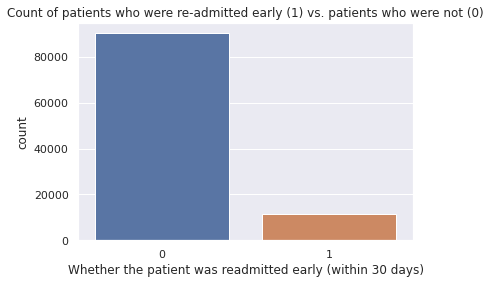

In [119]:
_ = sns.countplot(x='is_readmitted_early', data=df)
_ = plt.title('Count of patients who were re-admitted early (1) vs. patients who were not (0)')
_ = plt.xlabel('Whether the patient was readmitted early (within 30 days)')

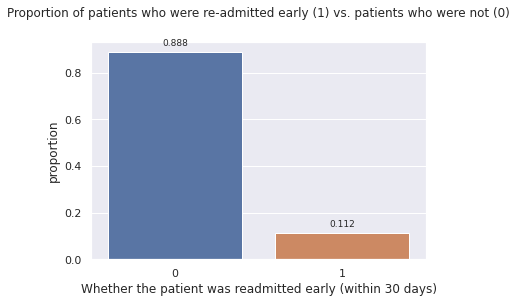

In [121]:
g = df.is_readmitted_early.value_counts(normalize=True).rename('proportion').to_frame().reset_index()
bplot = sns.barplot(x='index', y='proportion', data=g)

annotate_bar_values(bplot)
    
title = plt.title('Proportion of patients who were re-admitted early (1) vs. patients who were not (0)', pad=25)
_ = plt.xlabel('Whether the patient was readmitted early (within 30 days)')

There is a noticeable imbalance between the classes in our target feature: there are many more patient encounters with no early readmission (about 88.8% of the dataset) than those who with early readmission (about 11.1% of the dataset). This implies that accuracy may not be a good measure to indicate success, as an naive learner that predicts no early readmission 100% of the time will yield over a 81% accuracy. Using a confusion matrix, precision, recall, and other metrics in combination with accuracy may help establish a better idea on how our learner is performing. Alternatively, this may lead us to re-sample the dataset to restore balance or generating synthetic samples.

## 3. Discharges

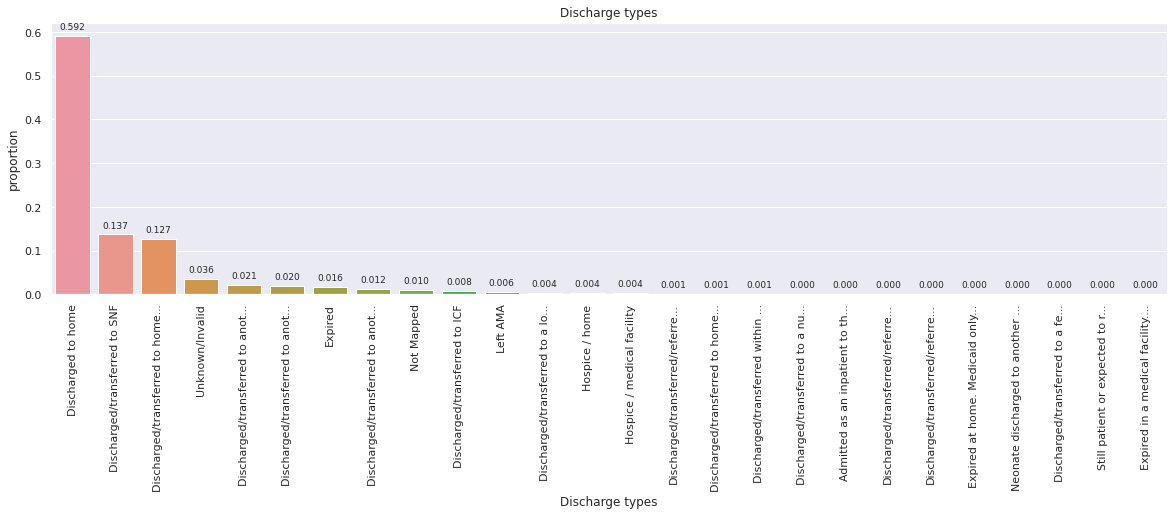

In [122]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
g = df.discharge_disposition_id.value_counts(normalize=True).sort_values(ascending=False).rename('proportion').to_frame().reset_index().rename(columns={'index':'discharge'})
bplot = sns.barplot(x='discharge', y='proportion', data=g, order=g.discharge)
_ = ax.set_xticklabels(truncate_xticklabels(bplot))
_ = plt.setp(bplot.get_xticklabels(), rotation=90)
_ = plt.xlabel('Discharge types')
_ = plt.title('Discharge types')
annotate_bar_values(bplot)

Naturally, we find that the largest category is having the patient discharged to their home. We also observe that most of the dataset is accounted by the first 5 categories. Another observation is that there are discharge categories related to hospice or death, which means that these patients will definitely not be readmitted to the hospital. These features include:
- Expired
- Hospice / home
- Hospice / medical facility
- Expired at home. Medicaid only, hospice.
- Expired in a medical facility. Medicaid only, hospice.
- Expired, place unknown. Medicaid only, hospice.

How many of the patient encounters fit into these categories? 

In [123]:
non_readmissible_features = ['Expired', 'Hospice / home', 'Hospice / medical facility', 'Expired at home. Medicaid only, hospice.', 'Expired in a medical facility. Medicaid only, hospice.', 'Expired, place unknown. Medicaid only, hospice.']
non_readmissable_encounters = df[df.discharge_disposition_id.isin(non_readmissible_features)]
non_readmissable_encounters

,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,is_readmitted,is_readmitted_early
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
293118,3327282,Caucasian,Female,7,Urgent,Expired,Clinic Referral,5,NA,Not Available,46,2,20,0,0,0,428,585,414,9,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,1,1,NO,0,0
450210,80177094,Caucasian,Female,8,Emergency,Expired,Emergency Room,7,NA,Not Available,72,1,27,0,0,0,432,997,427,9,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,0,1,NO,0,0
712350,110537262,AfricanAmerican,Female,5,Emergency,Expired,Emergency Room,4,NA,Not Available,58,1,16,0,0,0,403,V45,599,9,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,1,1,NO,0,0
1069716,34806888,Caucasian,Female,5,Urgent,Expired,Transfer from a hospital,2,NA,Not Available,35,1,10,1,0,0,997,427,403,8,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,1,1,NO,0,0
1260312,38688588,Caucasian,Male,7,Emergency,Expired,Emergency Room,9,NA,Not Available,56,2,30,0,0,0,410,491,276,9,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,0,1,NO,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442512770,41432652,Caucasian,Male,8,Emergency,Hospice / medical facility,Emergency Room,11,UN,Not Available,59,0,26,0,0,2,518,486,511,9,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,1,1,NO,0,0
442641206,141498050,Caucasian,Female,7,Elective,Hospice / medical facility,Physician Referral,4,CM,InternalMedicine,2,0,7,0,0,0,157,V66,250.02,8,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,1,1,NO,0,0
443139938,79902171,Caucasian,Male,9,Emergency,Hospice / home,Emergency Room,3,CP,Not Available,46,0,11,0,0,1,482,584,294,9,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,0,NO,0,0


Because this is a non-trivial fraction of our dataset, we will remove these observations to avoid affecting our exploratory data analysis. We will also perform this step during pre-processing.

In [124]:
df = df.drop(non_readmissable_encounters.index, errors='ignore')

In [125]:
df.discharge_disposition_id = df.discharge_disposition_id.cat.remove_unused_categories()

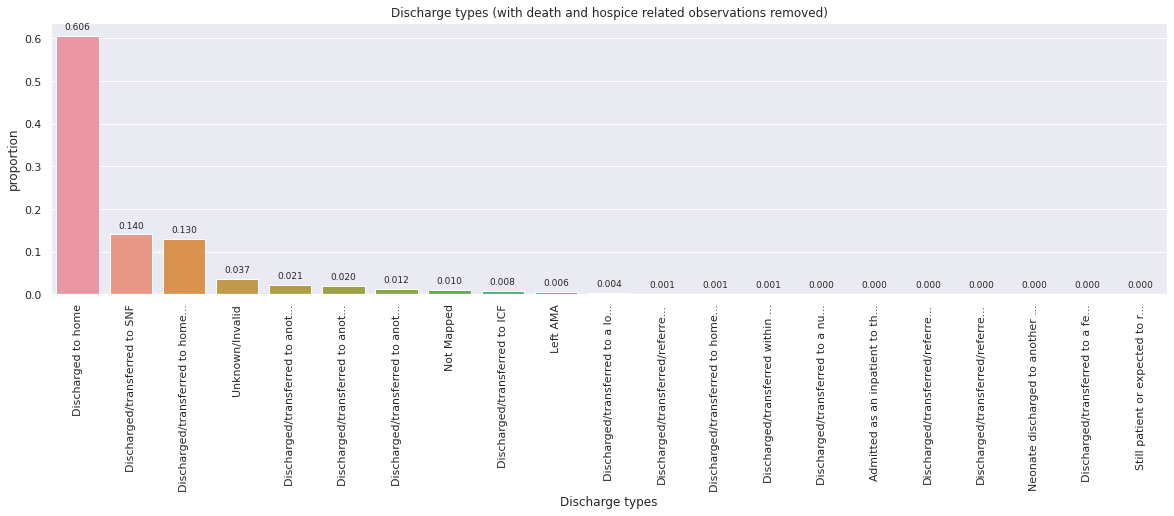

In [126]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
g = df.discharge_disposition_id.value_counts(normalize=True).sort_values(ascending=False).rename('proportion').to_frame().reset_index().rename(columns={'index':'discharge'})
bplot = sns.barplot(x='discharge', y='proportion', data=g, order=g.discharge)
_ = ax.set_xticklabels(truncate_xticklabels(bplot))
_ = plt.setp(bplot.get_xticklabels(), rotation=90)
_ = plt.xlabel('Discharge types')
_ = plt.title('Discharge types (with death and hospice related observations removed)')
annotate_bar_values(bplot)

We now take the top 10 largest discharge categories and determine if there is a noticeable difference among them with respect to early readmission.
- **Discharged to home**: A routine discharge to the patient's home, jail, or law enforcement
- **Discharged/transferred to SNF**: A transfer to a skilled nursing facility for patients that require rehabilitation, eldercare, physical, occupational, or speech therapy.
- **Discharged/transferred to home with home health service**: Discharged with a plan of home care written by medical professionals.
- **Unknown/Invalid**: A discharge type that is not known.
- **Discharged/transferred to another short term hospital** 
- **Discharged/transferred to another rehab fac including rehab units of a hospital**
- **Discharged/transferred to another type of inpatient care institution**
- **Not Mapped**: A provided description of discharge that did not correspond to an existing code.
- **Discharged/transferred to ICF**: A transfer to an intermediate care facility, typically state-designated.
- **Left AMA**: Left against medical advice

In [127]:
top_10_discharges = list(df.discharge_disposition_id.value_counts(normalize=True).sort_values(ascending=False).index)[:10]
top_10_discharges

['Discharged to home',
 'Discharged/transferred to SNF',
 'Discharged/transferred to home with home health service',
 'Unknown/Invalid',
 'Discharged/transferred to another short term hospital',
 'Discharged/transferred to another rehab fac including rehab units of a hospital .',
 'Discharged/transferred to another type of inpatient care institution',
 'Not Mapped',
 'Discharged/transferred to ICF',
 'Left AMA']

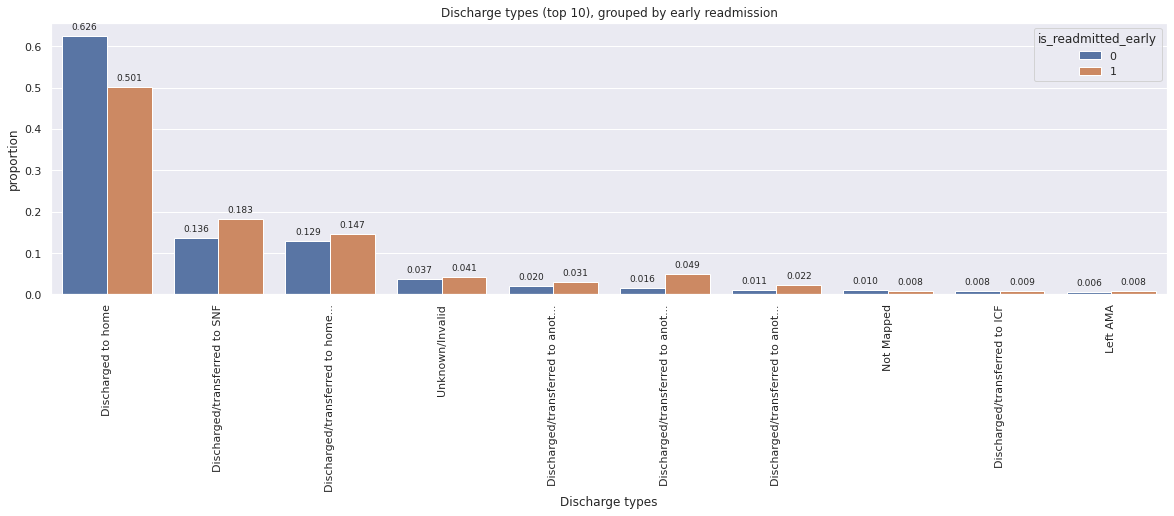

In [129]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
tmp = df[df.discharge_disposition_id.isin(top_10_discharges)].copy()
tmp.loc[:, 'discharge_disposition_id'] = tmp.discharge_disposition_id.cat.remove_unused_categories()

g = tmp.groupby('is_readmitted_early').discharge_disposition_id.value_counts(normalize=True)
g = g.sort_values(ascending=False).rename('proportion').to_frame().reset_index()
bplot = sns.barplot(x='discharge_disposition_id', y='proportion', hue='is_readmitted_early', data=g, order=list(tmp.discharge_disposition_id.value_counts(ascending=False).index))
_ = ax.set_xticklabels(truncate_xticklabels(bplot))
_ = plt.setp(bplot.get_xticklabels(), rotation=90)
_ = plt.xlabel('Discharge types')
_ = plt.title('Discharge types (top 10), grouped by early readmission')
annotate_bar_values(bplot)

Patients who have been readmitted early have a much smaller proportion of incidences where they were discharged to their home. This deficiency is compensated in the skilled nursing facility and home health service categories, implying that those who are more likely to be readmitted need more skilled attention and care.

## 4. Demographics

### 4.1. Race

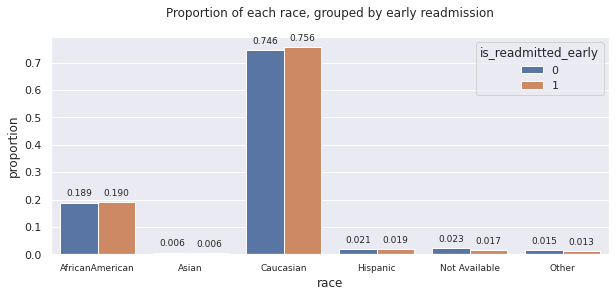

In [130]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
g = df.groupby('is_readmitted_early').race.value_counts(normalize=True).rename('proportion').to_frame().reset_index()
bplot = sns.barplot(x='race', y='proportion', hue='is_readmitted_early', data=g, ax=ax)
_ = plt.tick_params(axis='x', labelsize=9)
_ = plt.title('Proportion of each race, grouped by early readmission', pad=20)
annotate_bar_values(bplot)

### 4.2. Gender

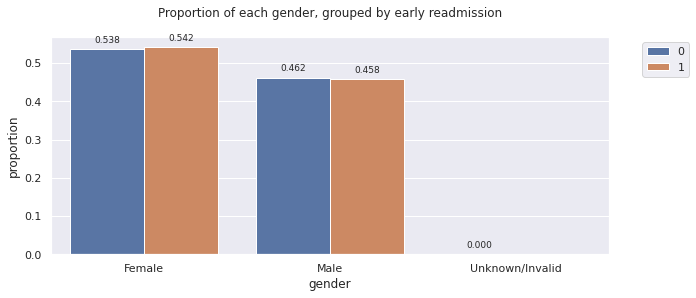

In [131]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
g = df.groupby('is_readmitted_early').gender.value_counts(normalize=True).rename('proportion').to_frame().reset_index()
bplot = sns.barplot(x='gender', y='proportion', hue='is_readmitted_early', data=g, ax=ax)
_ = plt.title('Proportion of each gender, grouped by early readmission', pad=20)
_ = plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
annotate_bar_values(bplot)

There appears to be a relatively even amount of male and female patients across gender. There are only three unknown or invalid gender values and they have all not been readmitted early. 

In [132]:
df[df.gender == 'Unknown/Invalid']

,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,is_readmitted,is_readmitted_early
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98634858,100695042,Other,Unknown/Invalid,7,Elective,Discharged to home,Physician Referral,1,NA,Cardiology,5,5,22,0,0,0,414,411,401,4,Not Available,Not Available,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,1,1,NO,0,0
226864668,60524946,Not Available,Unknown/Invalid,6,Emergency,Discharged to home,Emergency Room,1,CP,Not Available,38,1,6,0,0,0,808,873,E813,5,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,0,NO,0,0
257364294,78119847,Not Available,Unknown/Invalid,7,Emergency,Discharged/transferred to another rehab fac in...,Emergency Room,8,CP,Not Available,59,2,21,0,0,0,850,805,808,9,Not Available,Not Available,Steady,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,1,1,NO,0,0


### 4.3. Age 

In [133]:
g = df.groupby('is_readmitted_early').age.value_counts(normalize=True).rename('proportion').to_frame().reset_index()
age_mappings = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
age_mappings = dict(zip(range(0, len(age_mappings)), age_mappings))
g['age'] = g.age.map(age_mappings)
g.groupby('is_readmitted_early').age.value_counts(normalize=True)

is_readmitted_early  age     
0                    [0-10)      0.1
                     [10-20)     0.1
                     [20-30)     0.1
                     [30-40)     0.1
                     [40-50)     0.1
                     [50-60)     0.1
                     [60-70)     0.1
                     [70-80)     0.1
                     [80-90)     0.1
                     [90-100)    0.1
1                    [0-10)      0.1
                     [10-20)     0.1
                     [20-30)     0.1
                     [30-40)     0.1
                     [40-50)     0.1
                     [50-60)     0.1
                     [60-70)     0.1
                     [70-80)     0.1
                     [80-90)     0.1
                     [90-100)    0.1
Name: age, dtype: float64

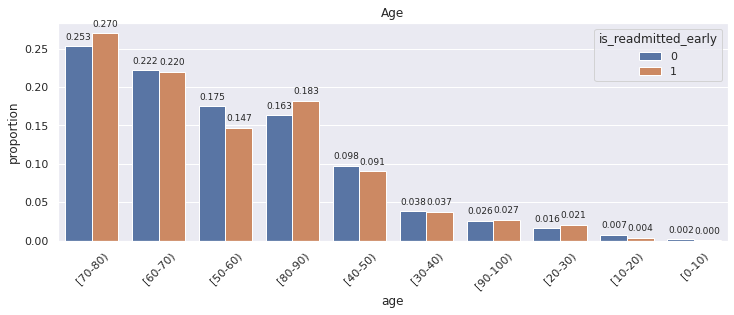

In [134]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
bplot = sns.barplot(x='age', y='proportion', hue='is_readmitted_early', data=g, ax=ax)
_ = plt.setp(bplot.get_xticklabels(), rotation=45)
_ = plt.title('Age')
annotate_bar_values(bplot, fontsize=9)

There is a higher proportion of patients within the \[70-80) (\~0.27 and \~0.25) and \[80-90) (\~0.18 vs \~0.16) age bracket that were readmitted early than not. Conversely, patients who were not readmitted early had a higher proportion  of patients within the \[50-60) bracket (\~0.17 and ~0.15) than those who were readmitted early.

## 5. Healthcare Payment Type

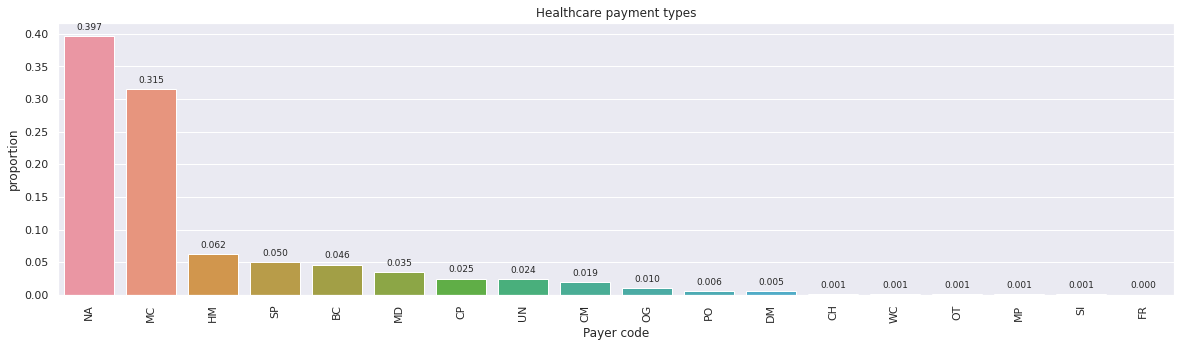

In [135]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
g = df.payer_code.value_counts(normalize=True).sort_values(ascending=False).rename('proportion').to_frame().reset_index().rename(columns={'index':'payer_code'})
bplot = sns.barplot(x='payer_code', y='proportion', data=g, order=g.payer_code)
_ = ax.set_xticklabels(truncate_xticklabels(bplot))
_ = plt.setp(bplot.get_xticklabels(), rotation=90)
_ = plt.xlabel('Payer code')
_ = plt.title('Healthcare payment types')
annotate_bar_values(bplot)

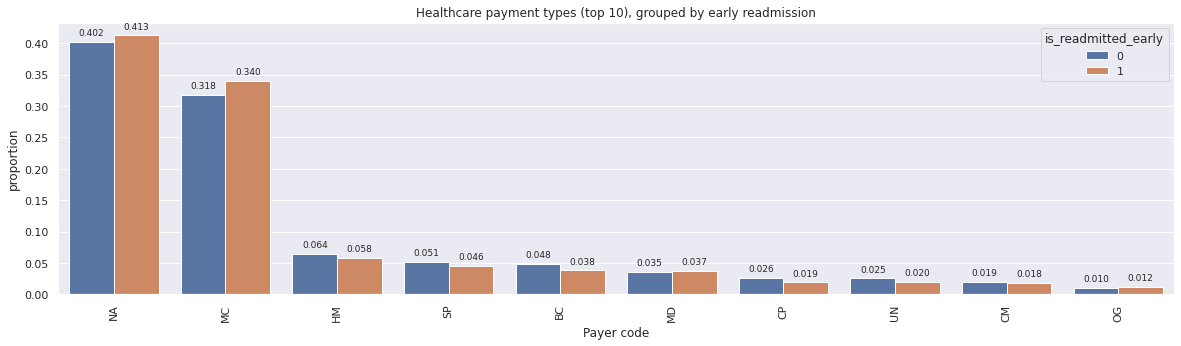

In [136]:
top_10_payer_codes = list(df.payer_code.value_counts(normalize=True).sort_values(ascending=False).index)[:10]

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
tmp = df[df.payer_code.isin(top_10_payer_codes)].copy()
tmp.loc[:, 'payer_code'] = tmp.payer_code.cat.remove_unused_categories()

g = tmp.groupby('is_readmitted_early').payer_code.value_counts(normalize=True)
g = g.sort_values(ascending=False).rename('proportion').to_frame().reset_index()
bplot = sns.barplot(x='payer_code', y='proportion', hue='is_readmitted_early', data=g, order=list(tmp.payer_code.value_counts(ascending=False).index))
_ = ax.set_xticklabels(truncate_xticklabels(bplot))
_ = plt.setp(bplot.get_xticklabels(), rotation=90)
_ = plt.xlabel('Payer code')
_ = plt.title('Healthcare payment types (top 10), grouped by early readmission')
annotate_bar_values(bplot)

There is a slight difference between the proportions of Not Available and Medicare payments between the early readmission groups. We may be able to bucket all other payer codes outside of the top ten into an 'Other' category since they account for so little of the dataset.

## 6. Medical Specialty
This feature represents the specialty of the admitting physician. There are several different specialties that only account for a small portion of the observations in the data. We'll focus on the top 10.

In [137]:
df.medical_specialty.nunique()

73

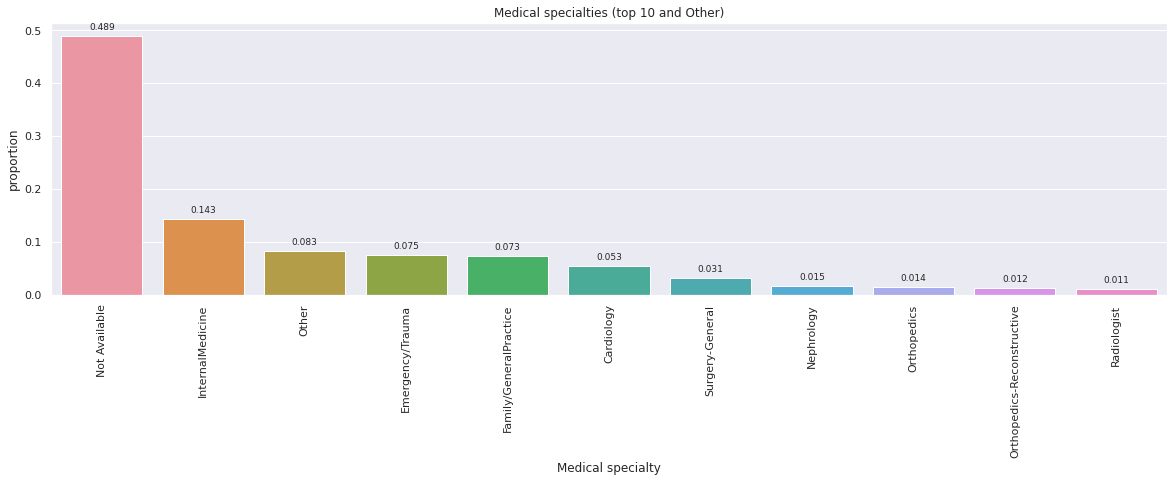

In [138]:
top_10_medical_specialties = list(df.medical_specialty.value_counts(normalize=True).sort_values(ascending=False).index)[:10]
other_specialties = list(set(df.medical_specialty.cat.categories) - set(top_10_medical_specialties))
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
tmp = df.copy()
tmp.medical_specialty = tmp.medical_specialty.astype('object')
tmp.loc[df.medical_specialty.isin(other_specialties), 'medical_specialty'] = 'Other'
tmp.medical_specialty = tmp.medical_specialty.astype('category')

g = tmp.medical_specialty.value_counts(normalize=True)
g = g.sort_values(ascending=False).rename('proportion').to_frame().reset_index().rename(columns={'index':'medical_specialty'})
bplot = sns.barplot(x='medical_specialty', y='proportion', data=g, order=list(tmp.medical_specialty.value_counts(ascending=False).index))
_ = ax.set_xticklabels(truncate_xticklabels(bplot))
_ = plt.setp(bplot.get_xticklabels(), rotation=90)
_ = plt.xlabel('Medical specialty')
_ = plt.title('Medical specialties (top 10 and Other)')
annotate_bar_values(bplot)

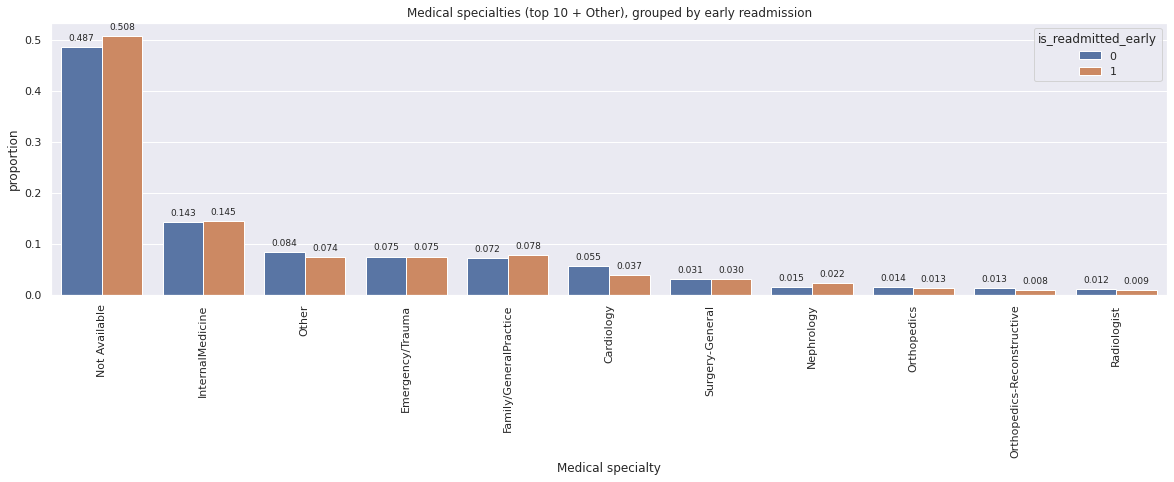

In [139]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)

g = tmp.groupby('is_readmitted_early').medical_specialty.value_counts(normalize=True)
g = g.sort_values(ascending=False).rename('proportion').to_frame().reset_index()
bplot = sns.barplot(x='medical_specialty', y='proportion', hue='is_readmitted_early', data=g, order=list(tmp.medical_specialty.value_counts(ascending=False).index))
_ = ax.set_xticklabels(truncate_xticklabels(bplot))
_ = plt.setp(bplot.get_xticklabels(), rotation=90)
_ = plt.xlabel('Medical specialty')
_ = plt.title('Medical specialties (top 10 + Other), grouped by early readmission')
annotate_bar_values(bplot)

Patient encounters that did not result in early readmission had a lower proportion of Not Available medical specialties, which may mean that these patients did not require a specialist.

## 7. Patient Admission

Admission is described in two ways: admission type (the type of reason for the patient admission) and admission source (a description on where the patient came from).

### 7.1. Admission Type



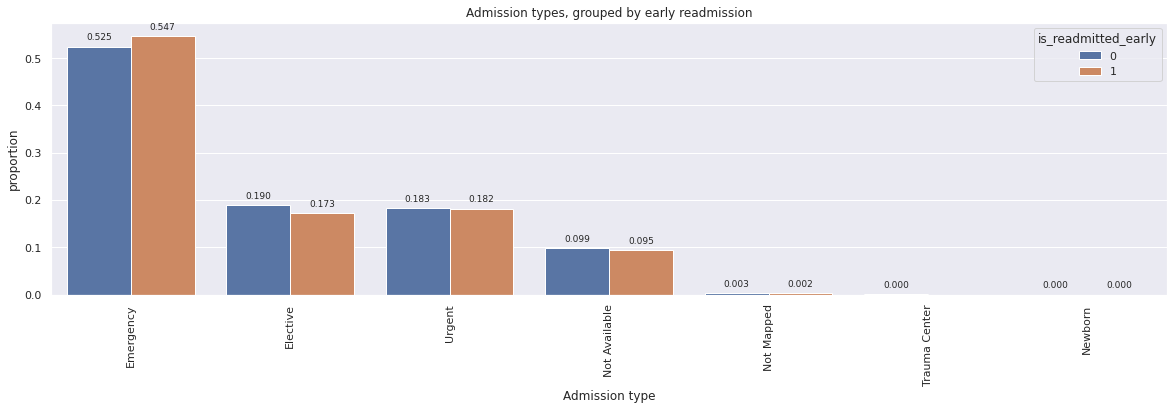

In [140]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)

g = df.groupby('is_readmitted_early').admission_type_id.value_counts(normalize=True)
g = g.sort_values(ascending=False).rename('proportion').to_frame().reset_index()
bplot = sns.barplot(x='admission_type_id', y='proportion', hue='is_readmitted_early', data=g, order=df.admission_type_id.value_counts(normalize=True).sort_values(ascending=False).index)
_ = ax.set_xticklabels(truncate_xticklabels(bplot))
_ = plt.setp(bplot.get_xticklabels(), rotation=90)
_ = plt.xlabel('Admission type')
_ = plt.title('Admission types, grouped by early readmission')
annotate_bar_values(bplot)

### 7.2. Admission Source

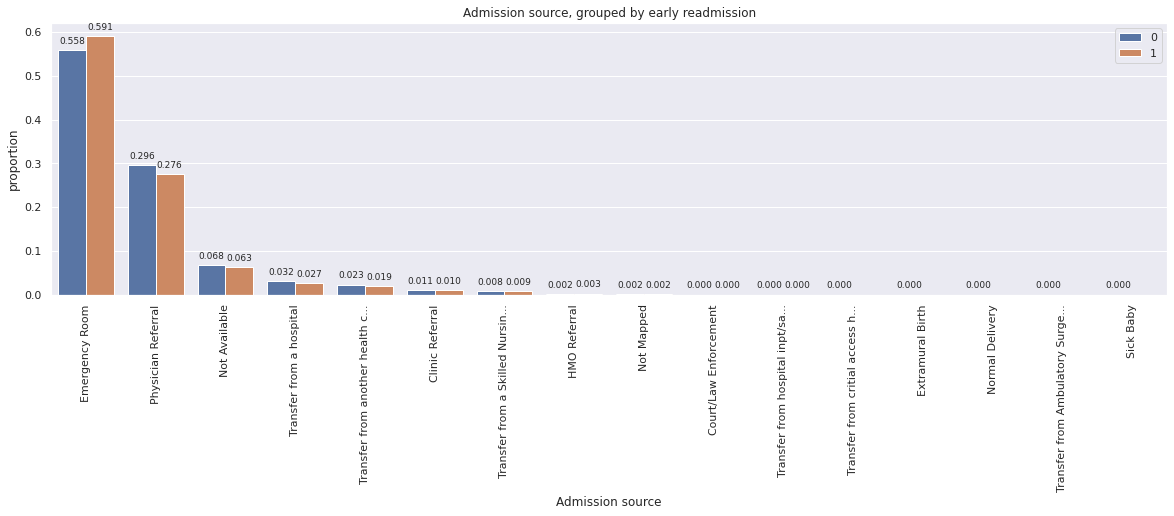

In [144]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)

df.admission_source_id.cat.categories

g = df.groupby('is_readmitted_early').admission_source_id.value_counts(normalize=True)
g = g.sort_values(ascending=False).rename('proportion').to_frame().reset_index()
bplot = sns.barplot(x='admission_source_id', y='proportion', hue='is_readmitted_early', data=g, order=df.admission_source_id.value_counts(normalize=True).sort_values(ascending=False).index)
_ = ax.set_xticklabels(truncate_xticklabels(bplot))
_ = plt.setp(bplot.get_xticklabels(), rotation=90)
_ = plt.xlabel('Admission source')
_ = plt.title('Admission source, grouped by early readmission')
_ = plt.legend(loc='upper right')
annotate_bar_values(bplot)

Emergency patient encounters account for the largest portion of the dataset. Patients who were readmitted early have a higher proportion of emergency room admission sources than those who were not.

## 8. Administered Tests

### 8.1. HbA1c Result

In [96]:
df.groupby('is_readmitted_early').A1Cresult.value_counts(normalize=True)

is_readmitted_early  A1Cresult    
0                    Not Available    0.827773
                     >8               0.083245
                     Norm             0.050449
                     >7               0.038533
1                    Not Available    0.852130
                     >8               0.071504
                     Norm             0.042514
                     >7               0.033852
Name: A1Cresult, dtype: float64

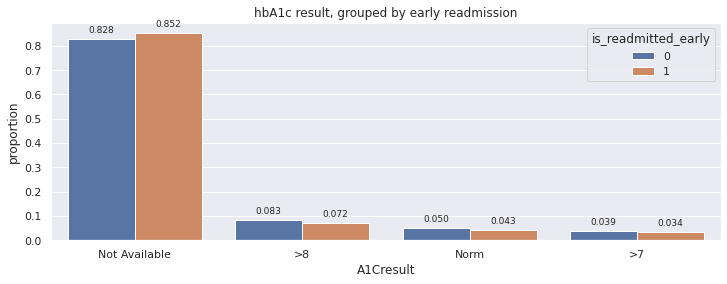

In [24]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
g = df.groupby('is_readmitted_early').A1Cresult.value_counts(normalize=True).rename('proportion').to_frame().reset_index()
bplot = sns.barplot(x='A1Cresult', y='proportion', hue='is_readmitted_early', data=g, ax=ax)
_ = plt.title('hbA1c result, grouped by early readmission')
annotate_bar_values(bplot)

### 8.2. Glucose Serum Test

In [25]:
df.groupby('is_readmitted_early').max_glu_serum.value_counts(normalize=True)

is_readmitted_early  max_glu_serum
0                    Not Available    0.948937
                     Norm             0.025571
                     >200             0.014029
                     >300             0.011462
1                    Not Available    0.941930
                     Norm             0.025986
                     >200             0.016263
                     >300             0.015821
Name: max_glu_serum, dtype: float64

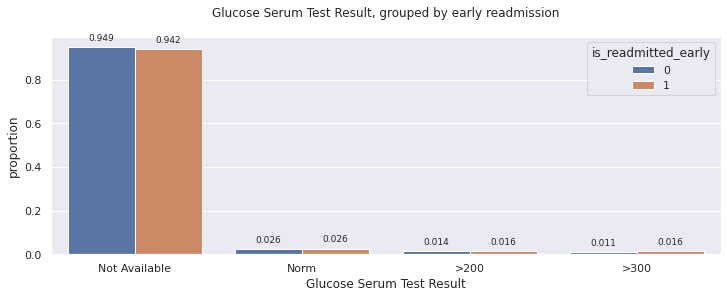

In [26]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
g = df.groupby('is_readmitted_early').max_glu_serum.value_counts(normalize=True).rename('proportion').to_frame().reset_index()
bplot = sns.barplot(x='max_glu_serum', y='proportion', hue='is_readmitted_early', data=g, ax=ax)
_ = plt.title('Glucose Serum Test Result, grouped by early readmission', pad=20)
_ = plt.xlabel('Glucose Serum Test Result')
annotate_bar_values(bplot)

## 9. Diagnoses
To increase interpretability we need to translate these ICD-9 codes to a human readable format.
### 9.1. Primary Diagnosis

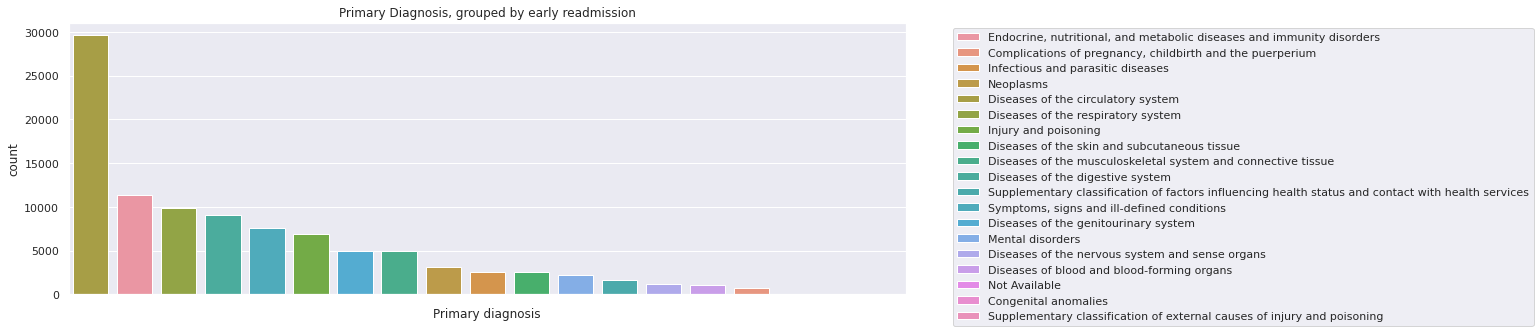

In [27]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
g = df.copy()
g['diag_1'] = g.diag_1.apply(icd9_to_classification)
g.loc[g.diag_1.isnull(), 'diag_1'] = 'Not Available'
bplot = sns.countplot(x='diag_1', hue='diag_1', data=g, ax=ax, dodge=False, order=g.diag_1.value_counts().index)
_ = ax.xaxis.set_ticklabels([])
_ = plt.xlabel('Primary diagnosis')
_ = plt.setp(bplot.get_xticklabels(), rotation=90)
_ = plt.title('Primary Diagnosis, grouped by early readmission')
_ = plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

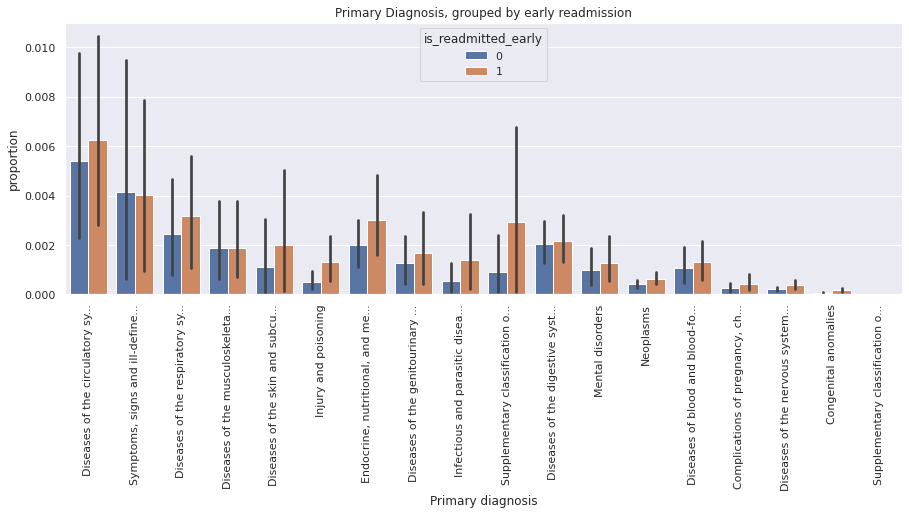

In [28]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
g = df.groupby('is_readmitted_early').diag_1.value_counts(normalize=True).rename('proportion').to_frame().reset_index()
g['diag_1'] = g.diag_1.apply(icd9_to_classification)
bplot = sns.barplot(x='diag_1', y='proportion', hue='is_readmitted_early', data=g, ax=ax)
_ = ax.set_xticklabels(truncate_xticklabels(bplot))
_ = plt.setp(bplot.get_xticklabels(), rotation=90)
_ = plt.xlabel('Primary diagnosis')
_ = plt.title('Primary Diagnosis, grouped by early readmission')

### 9.2. Secondary Diagnosis

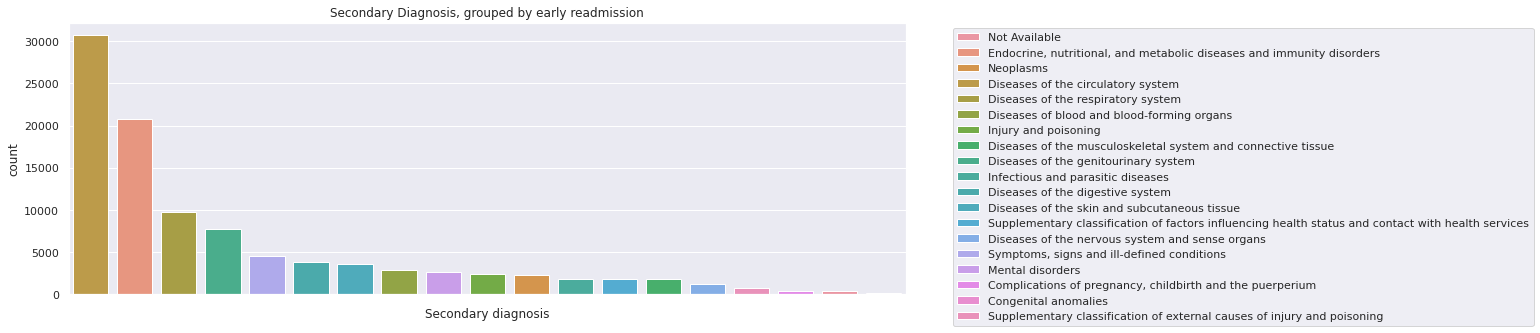

In [29]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
g = df.copy()
g['diag_2'] = g.diag_2.apply(icd9_to_classification)
g.loc[g.diag_2.isnull(), 'diag_2'] = 'Not Available'
bplot = sns.countplot(x='diag_2', hue='diag_2', data=g, ax=ax, dodge=False, order=g.diag_2.value_counts().index)
_ = ax.xaxis.set_ticklabels([])
_ = plt.xlabel('Secondary diagnosis')
_ = plt.setp(bplot.get_xticklabels(), rotation=90)
_ = plt.title('Secondary Diagnosis, grouped by early readmission')
_ = plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

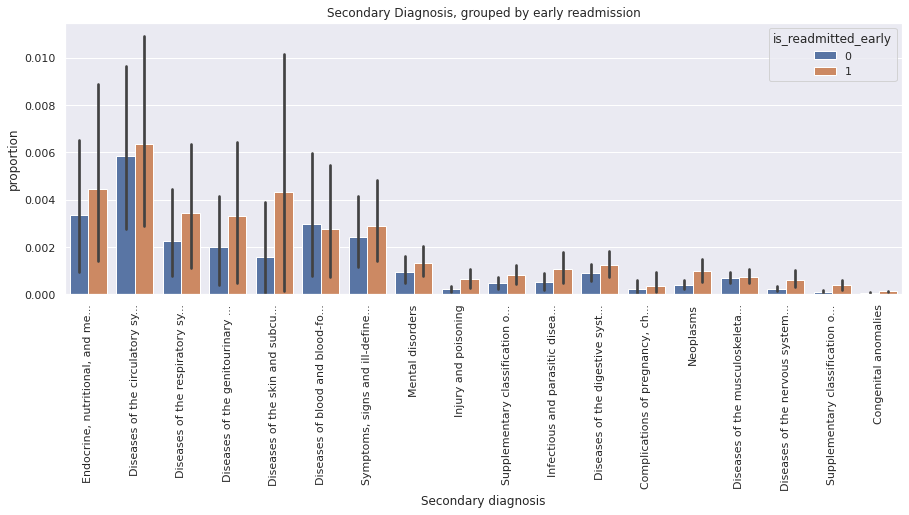

In [30]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
g = df.groupby('is_readmitted_early').diag_2.value_counts(normalize=True).rename('proportion').to_frame().reset_index()
g['diag_2'] = g.diag_2.apply(icd9_to_classification)
bplot = sns.barplot(x='diag_2', y='proportion', hue='is_readmitted_early', data=g, ax=ax)
_ = ax.set_xticklabels(truncate_xticklabels(bplot))
_ = plt.setp(bplot.get_xticklabels(), rotation=90)
_ = plt.xlabel('Secondary diagnosis')
_ = plt.title('Secondary Diagnosis, grouped by early readmission')

### 9.3. Tertiary Diagnosis

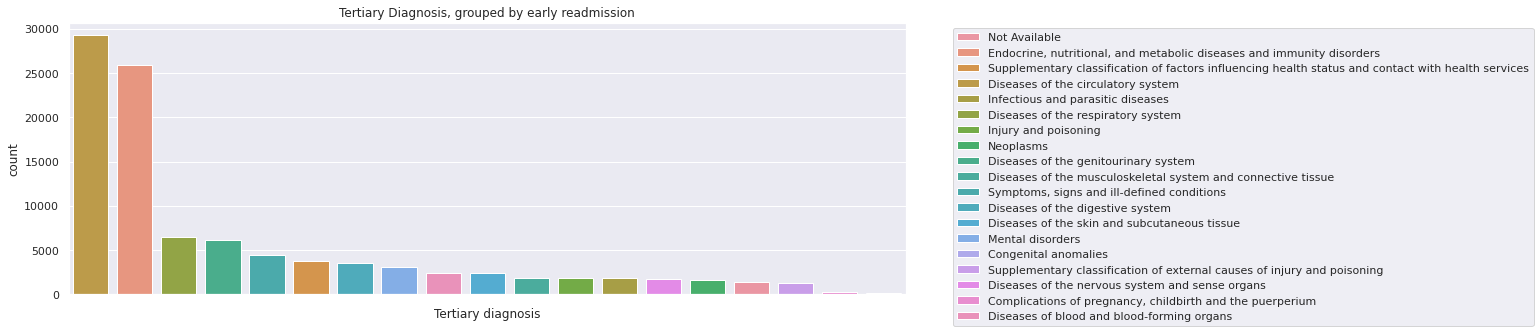

In [31]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
g = df.copy()
g['diag_3'] = g.diag_3.apply(icd9_to_classification)
g.loc[g.diag_3.isnull(), 'diag_3'] = 'Not Available'
bplot = sns.countplot(x='diag_3', hue='diag_3', data=g, ax=ax, dodge=False, order=g.diag_3.value_counts().index)
_ = ax.xaxis.set_ticklabels([])
_ = plt.xlabel('Tertiary diagnosis')
_ = plt.setp(bplot.get_xticklabels(), rotation=90)
_ = plt.title('Tertiary Diagnosis, grouped by early readmission')
_ = plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

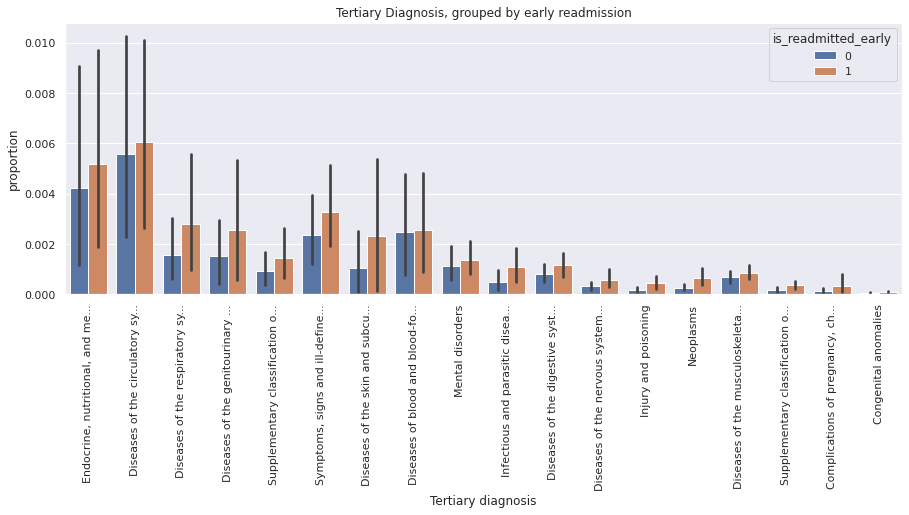

In [32]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
g = df.groupby('is_readmitted_early').diag_3.value_counts(normalize=True).rename('proportion').to_frame().reset_index()
g['diag_3'] = g.diag_3.apply(icd9_to_classification)
bplot = sns.barplot(x='diag_3', y='proportion', hue='is_readmitted_early', data=g, ax=ax)
_ = ax.set_xticklabels(truncate_xticklabels(bplot))
_ = plt.setp(bplot.get_xticklabels(), rotation=90)
_ = plt.xlabel('Tertiary diagnosis')
_ = plt.title('Tertiary Diagnosis, grouped by early readmission')

### 9.4. Number of Diagnoses

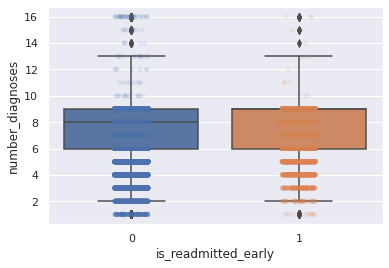

In [33]:
_ = sns.stripplot(x='is_readmitted_early', y='number_diagnoses', data=df, jitter=True, alpha=0.1)
_ = sns.boxplot(x='is_readmitted_early', y='number_diagnoses', data=df)

## 10. Medication-related features 
### 10.1. Change
The `change` feature is a binary categorical feature that describes whether a patient has had their medication changed during their encounter.


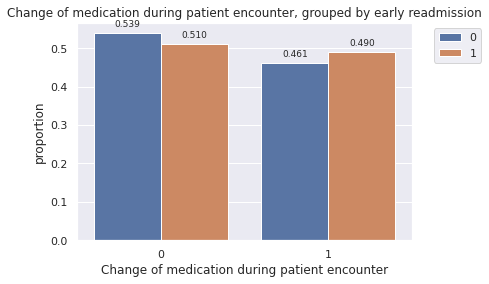

In [34]:
g = df.groupby('is_readmitted_early').change.value_counts(normalize=True).rename('proportion').to_frame().reset_index()
bplot = sns.barplot(x='change', y='proportion', hue='is_readmitted_early', data=g)
_ = plt.title('Change of medication during patient encounter, grouped by early readmission') 
_ = plt.xlabel('Change of medication during patient encounter')
_ = plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
annotate_bar_values(bplot)

Patients who are not readmitted early have a slightly higher proportion of those who did not change their medication during their patient encounter.

### 10.2. Diabetes Medication
The `diabetesMed` feature is a binary categorical feature that indicates whether or not the patient is on diabetes medication.

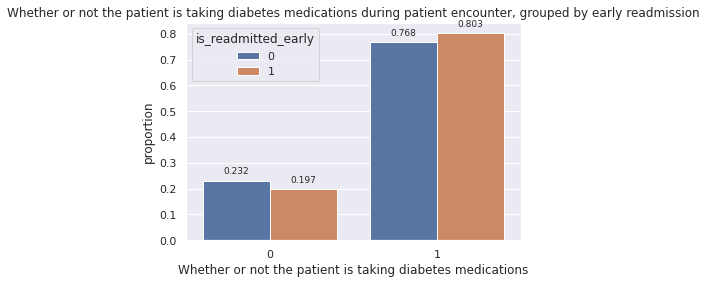

In [35]:
g = df.groupby('is_readmitted_early').diabetesMed.value_counts(normalize=True).rename('proportion').to_frame().reset_index()
bplot = sns.barplot(x='diabetesMed', y='proportion', hue='is_readmitted_early', data=g)
_ = plt.title('Whether or not the patient is taking diabetes medications during patient encounter, grouped by early readmission') 
_ = plt.xlabel('Whether or not the patient is taking diabetes medications')
annotate_bar_values(bplot)

Patients who are readmitted early have a slightly higher proportion of those who are taking diabetes medication.

### 10.3. Specific Medications

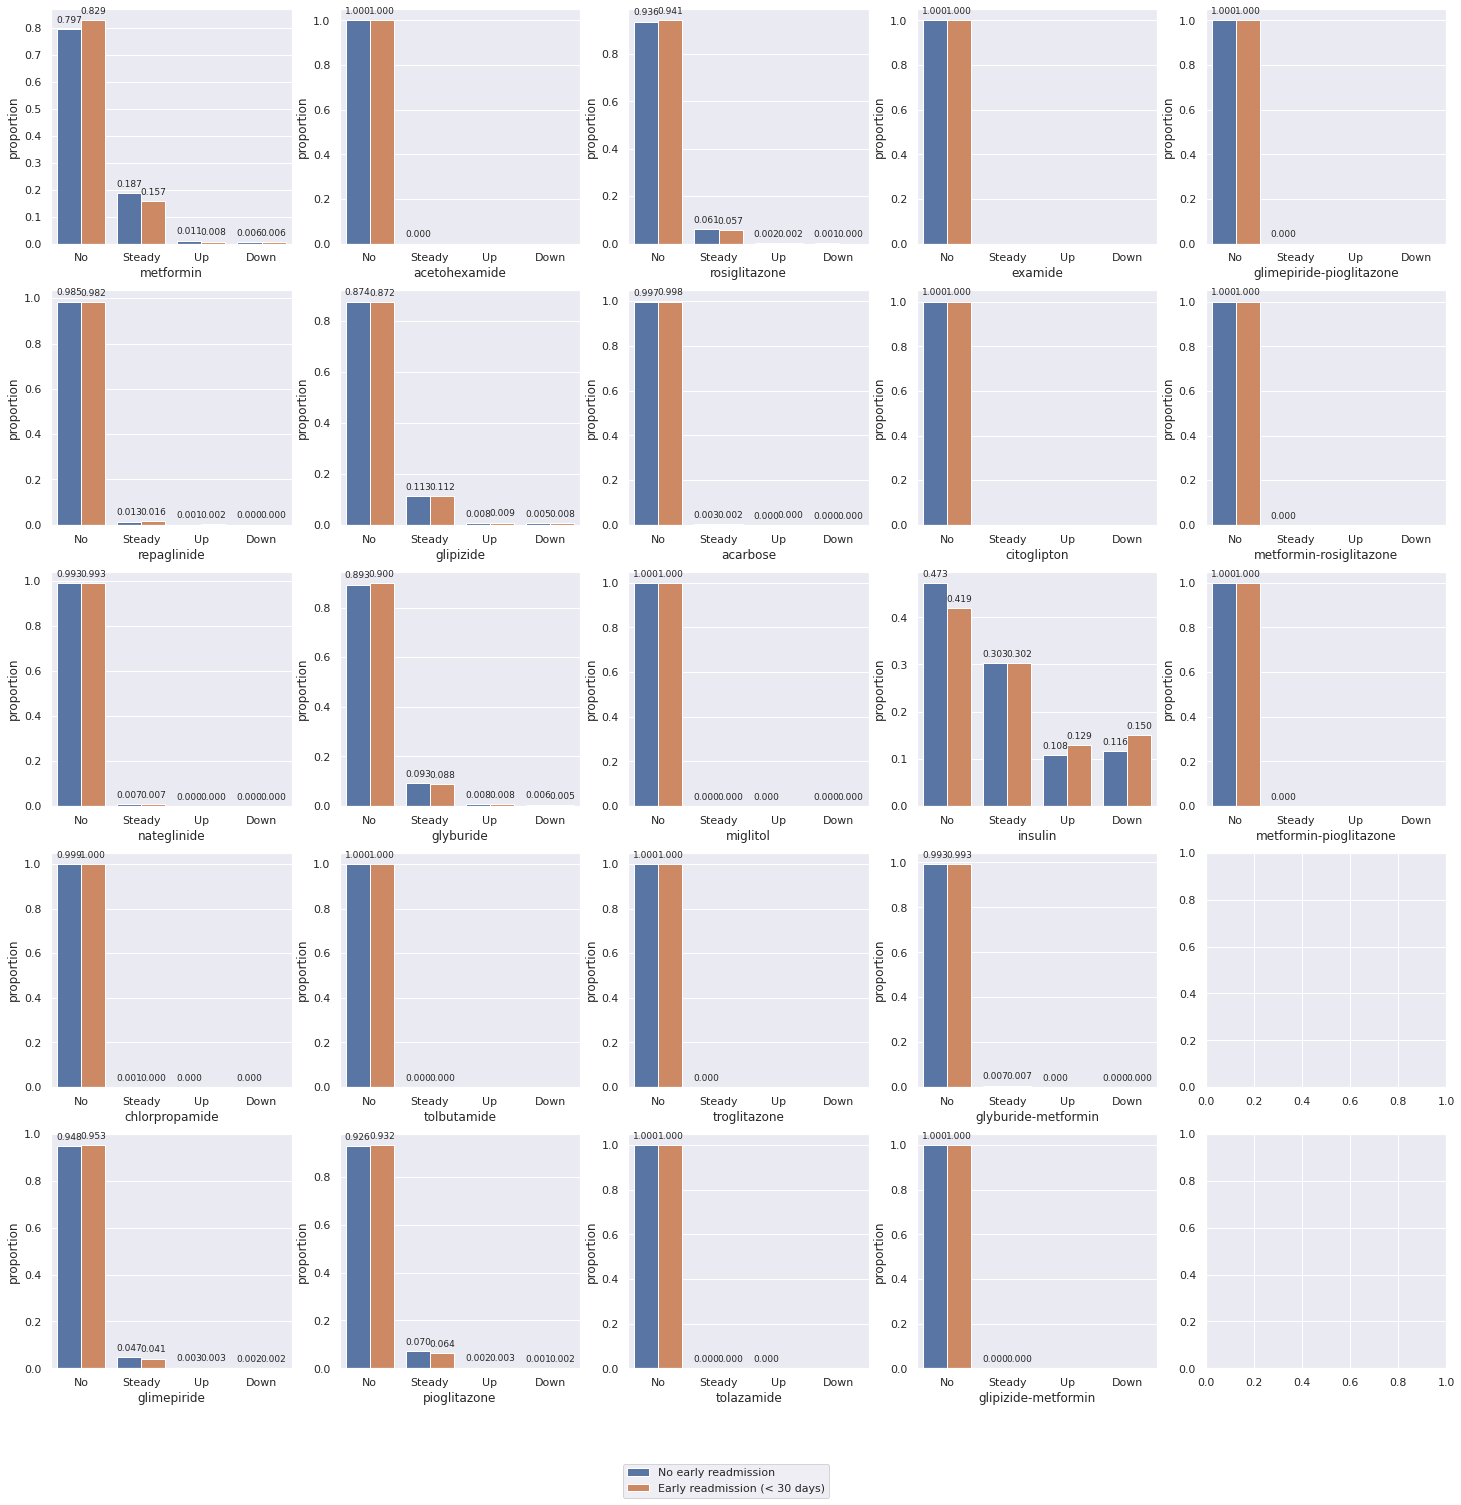

In [36]:
medication_features = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

nrow = 5
ncol = 5
fig, axes = plt.subplots(nrow, ncol)
fig.set_figheight(25)
fig.set_figwidth(25)

for i, f in enumerate(medication_features):
    ax = axes[i % nrow, i // ncol]
    g = df.groupby('is_readmitted_early')[f].value_counts(normalize=True).rename('proportion').to_frame().reset_index()
    bplot = sns.barplot(x=f, y='proportion', hue='is_readmitted_early', data=g, ax=ax)
    annotate_bar_values(bplot, ax=ax)
    ax.get_legend().remove()
    
    
lines = []
labels = []
for ax in axes.flatten():
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)
_= fig.legend(lines, ['No early readmission' if int(l) == 0 else 'Early readmission (< 30 days)' for l in list(set(labels))],            
           bbox_to_anchor=(0.5, 0.05), loc='lower center')

Features like tolazamide, tolbutamide, troglitazone, metformin-pioglitazone, metformin-rosiglitazone, examide,  citoglipton, acetohexamide, and glimepiride-pioglitazone are fairly homogeneous. We'll investigate further to see the actually number of observations that have heterogeneous values:

In [37]:
df.examide.value_counts()

No        99343
Steady        0
Up            0
Down          0
Name: examide, dtype: int64

In [38]:
df.citoglipton.value_counts()

No        99343
Steady        0
Up            0
Down          0
Name: citoglipton, dtype: int64

In [39]:
df.tolazamide.value_counts()

No        99304
Steady       38
Up            1
Down          0
Name: tolazamide, dtype: int64

In [40]:
df.tolbutamide.value_counts() 

No        99322
Steady       21
Up            0
Down          0
Name: tolbutamide, dtype: int64

In [41]:
df.troglitazone.value_counts()

No        99340
Steady        3
Up            0
Down          0
Name: troglitazone, dtype: int64

In [42]:
df['metformin-pioglitazone'].value_counts()

No        99342
Steady        1
Up            0
Down          0
Name: metformin-pioglitazone, dtype: int64

In [43]:
df['metformin-rosiglitazone'].value_counts()

No        99341
Steady        2
Up            0
Down          0
Name: metformin-rosiglitazone, dtype: int64

In [44]:
df.acetohexamide.value_counts()

No        99342
Steady        1
Up            0
Down          0
Name: acetohexamide, dtype: int64

In [45]:
df['glimepiride-pioglitazone'].value_counts()

No        99342
Steady        1
Up            0
Down          0
Name: glimepiride-pioglitazone, dtype: int64

Examide and citoglipton are completely homogeneous. Troglitazone, metformin-pioglitazone, gimepiride-pioglitazone, acetohexamide, and metformin-rosiglitazone all 3 observations or fewer that have patients who are taking them. In the feature engineering step, I feel comfortable with removing these columns to avoid adding unnecessary noise to our model. This also reduces our dimensionality quite a bit.

## 11. Numerical features

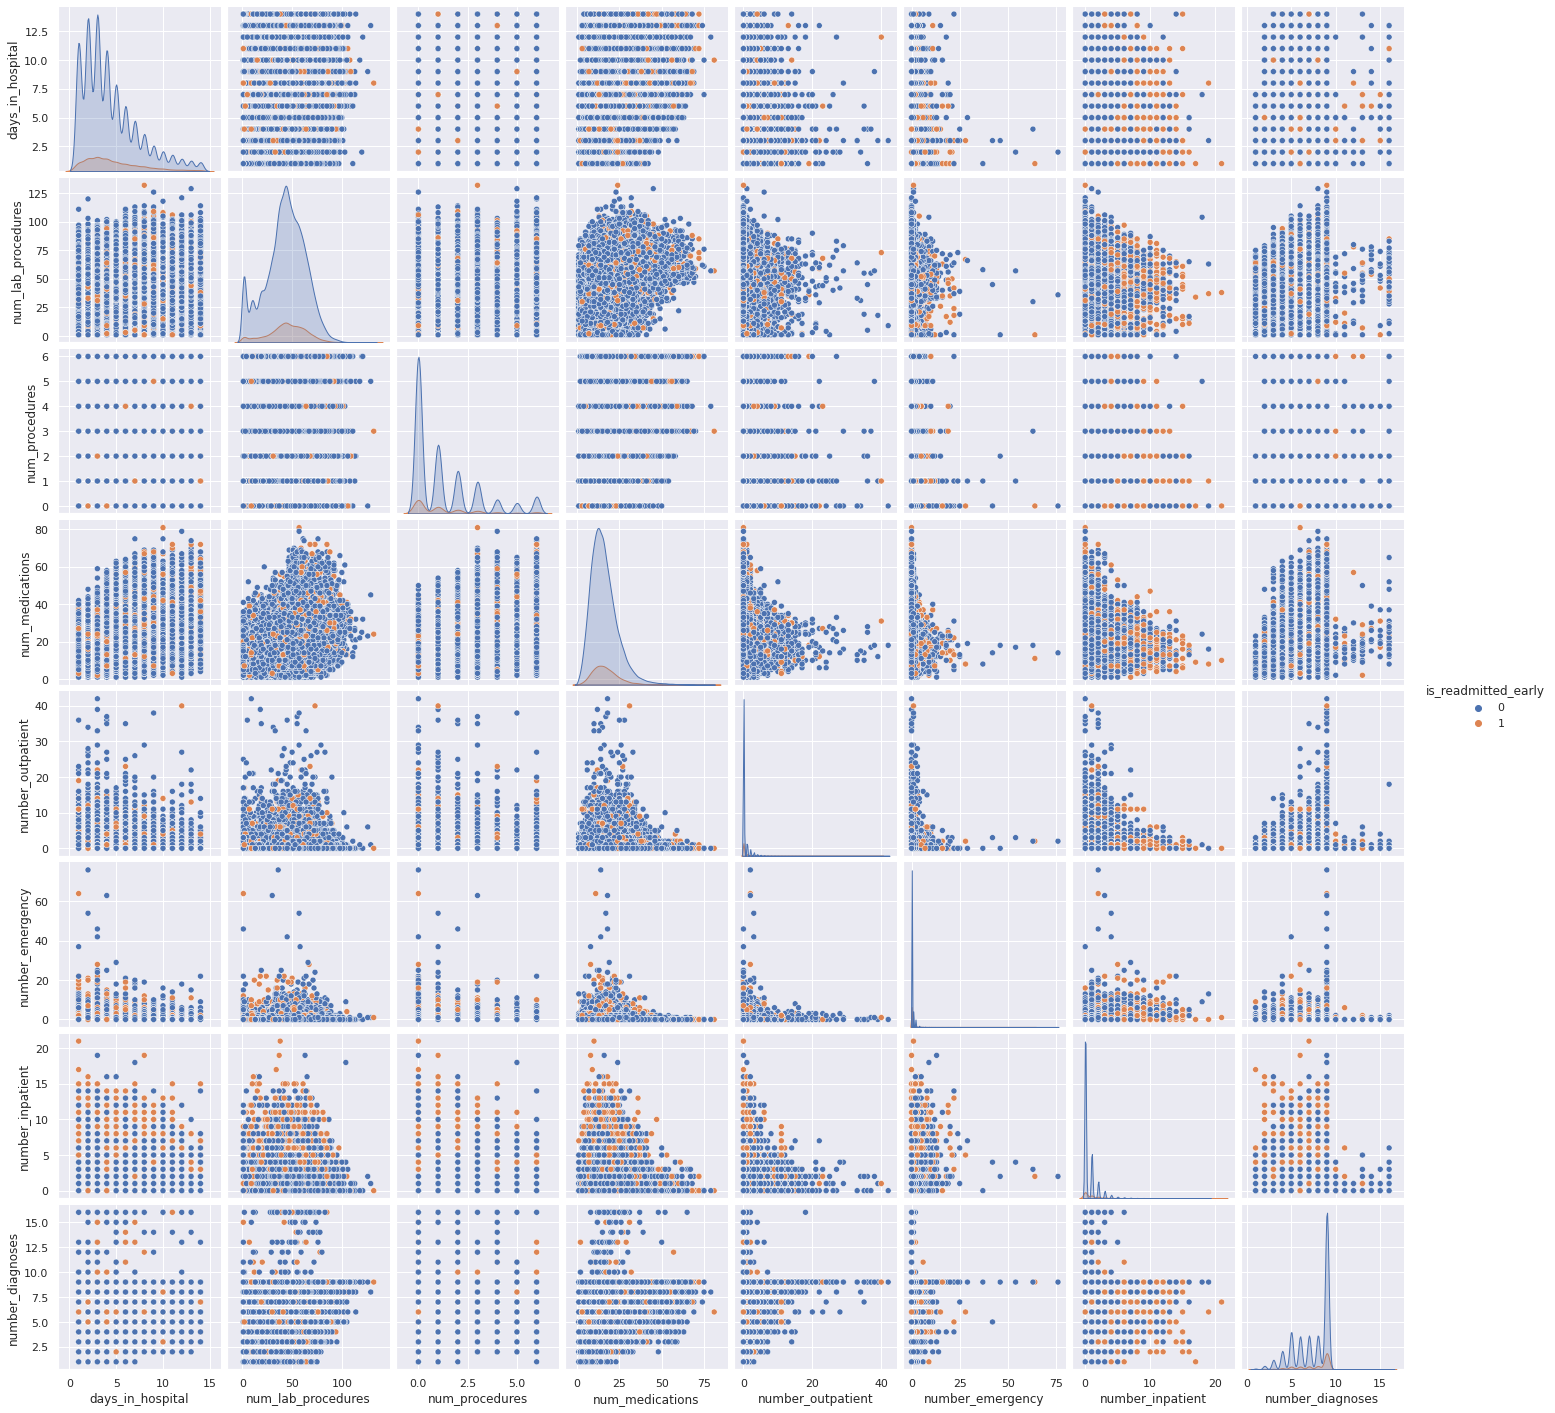

In [46]:
_ = sns.pairplot(data=df_cont, hue='is_readmitted_early')

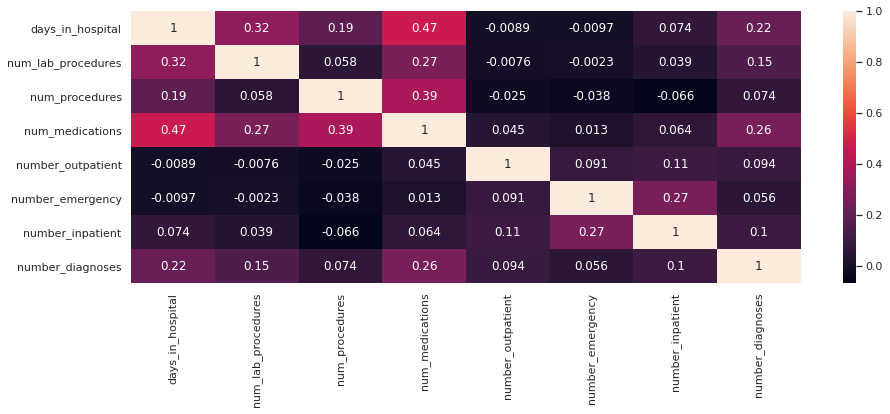

In [47]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
corr = df_cont.drop(columns=['is_readmitted_early']).corr()
_ = sns.heatmap(corr, annot=True, ax=ax)

There are noticeable correlations between number of medications and number of procedures and number of days in the hospital and number of medications.

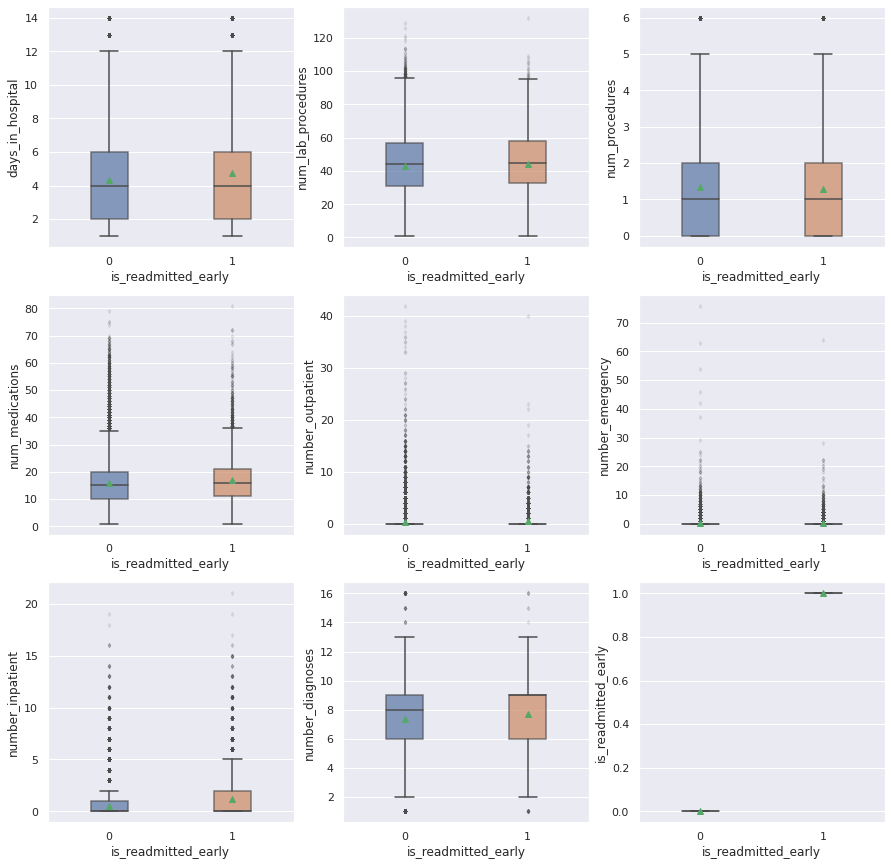

In [48]:
fig, axes = plt.subplots(3, 3)
fig.set_figheight(15)
fig.set_figwidth(15)

for i, c in enumerate(df_cont.columns):
    _ = sns.boxplot(y=c, x='is_readmitted_early', data=df, ax=axes[i//3, i%3],
                    showmeans=True, boxprops=dict(alpha=.7), width=.3,
                    flierprops=dict(markersize=3,alpha=0.1,
              linestyle='none'))